See here: https://github.com/fchollet/keras/issues/1061

/Users/davidcottrell/anaconda/envs/35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


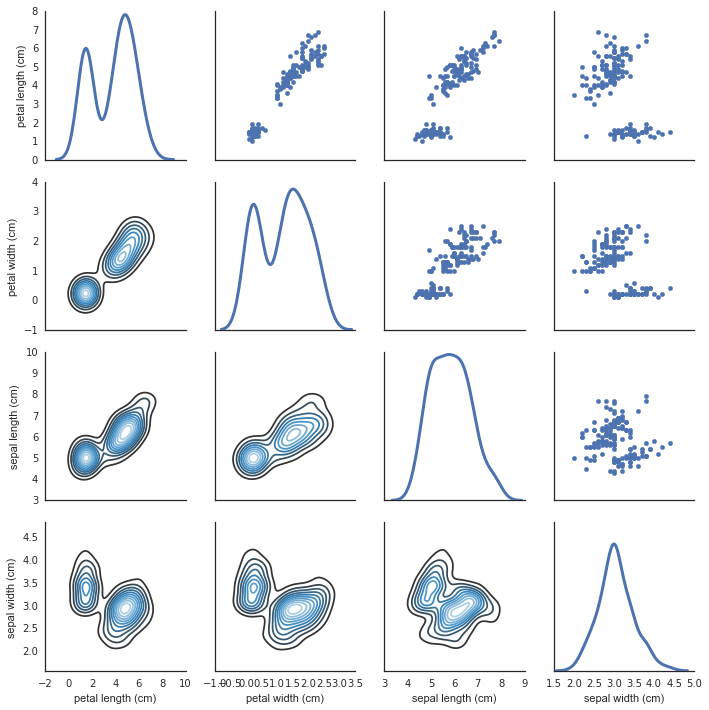

In [90]:
### load data
from imp import reload
import site; site.addsitedir('..')
import mylib.data as md
reload(md)

df, dfd = md.iris()

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")

g = sns.PairGrid(df, diag_sharey=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)

In [23]:
"""
See here: https://github.com/fchollet/keras/issues/1061
"""
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Layer
from keras.optimizers import SGD

### load data
from imp import reload
import site; site.addsitedir('..')
import mylib.data as md
reload(md)

df, dfd = md.iris()

y_cols = ['petal length (cm)']
x_cols = [x for x in dfd.columns if x not in y_cols]

from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dfd[x_cols].values,
        dfd[y_cols].values, test_size=0.1)

input_dim = X_train.shape[1]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Layer
from keras.optimizers import SGD
from theano import tensor as T
import theano

class GMMActivation(Layer):
    """
    GMM-like activation function.
    Assumes that input has (D+2)*M dimensions, where D is the dimensionality of the
    target data (y). The first M*D features are treated as means of y, the next M features as
    standard devs and the last M features as mixture components of the GMM.
    """
    def __init__(self, M, D, **kwargs):
        super(GMMActivation, self).__init__(**kwargs)
        self.M = M # i.e. number of Gaussian components
        self.D = D # i.e. y.shape[1]
        print("init: shape is {} {}".format(M, D))

    def get_output(self, train=False):
        X = self.get_input(train)
        # D = T.shape(X)[1]/self.M - 2
        D = self.D
        M = self.M
        # leave mu values as they are since they're unconstrained
        # scale sigmas with exp, s.t. all values are non-negative
        X = T.set_subtensor(X[:,D * M:(D + 1) * M], T.exp(X[:,D * M:(D + 1) * M]))
        # scale alphas with softmax, s.t. that all values are between [0,1] and sum up to 1
        X = T.set_subtensor(X[:,(D + 1) * M:(D + 2) * M], T.nnet.softmax(X[:,(D + 1) * M:(D + 2) * M]))
        return X

    def get_config(self):
        config = {"name": self.__class__.__name__,
                  "M": self.M,
                  "D": self.D}
        base_config = super(GMMActivation, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

def gmm_loss_factory(M, D):
    def gmm_loss(y_true, y_pred):
        """
        GMM loss function with extremely confusing variable names.
        
        Assumes that y_pred has (D+2)*M dimensions and y_true has D dimensions. The first
        M*D features are treated as means, the next M features as standard devs and the last
        M features as mixture components of the GMM.
        """
        def loss(m, M, D, y_true, y_pred):
            mu = y_pred[:,D * m:(m + 1) * D]
            sigma = y_pred[:,D * M + m]
            alpha = y_pred[:,(D + 1) * M + m]
            return (alpha / sigma) * T.exp(-T.sum(T.sqr(mu - y_true), -1)/(2 * sigma**2))

        # D = T.shape(y_true)[1]
        # M = T.shape(y_pred)[1]/(D+2)
        seq = T.arange(M)
        result, _ = theano.scan(fn=loss, outputs_info=None, sequences=seq, non_sequences=[M, D, y_true, y_pred])
        return -T.log(result.sum(0))
    return gmm_loss

M = 4
D = y_train.shape[1]
gmm_loss = gmm_loss_factory(M, D)
model_gmm = Sequential()
model_gmm.add(Dense(input_dim=input_dim, output_dim=(D + 2) * M))
model_gmm.add(GMMActivation(M, D))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.5, nesterov=True)

# model_gmm.compile(loss=gmm_loss, optimizer='adam')
model_gmm.compile(loss=gmm_loss, optimizer=sgd)

Overwriting gmm.py


In [18]:
X_train.shape, y_train.shape

((135, 6), (135, 1))

In [19]:
%%time
out = model_gmm.fit(X_train, y_train, nb_epoch=10, batch_size=30, validation_data=(X_test, y_test), show_accuracy=True)

Train on 135 samples, validate on 15 samples
Epoch 1/10
135/135 [==============================] - 0s - loss: 3.2519 - acc: 0.0000e+00 - val_loss: 1.9899 - val_acc: 0.0000e+00
Epoch 2/10
135/135 [==============================] - 0s - loss: 1.6924 - acc: 0.0000e+00 - val_loss: 1.5365 - val_acc: 0.0000e+00
Epoch 3/10
135/135 [==============================] - 0s - loss: 1.2742 - acc: 0.0000e+00 - val_loss: 1.1803 - val_acc: 0.0000e+00
Epoch 4/10
135/135 [==============================] - 0s - loss: 1.0562 - acc: 0.0000e+00 - val_loss: 1.0159 - val_acc: 0.0000e+00
Epoch 5/10
135/135 [==============================] - 0s - loss: 0.9800 - acc: 0.0000e+00 - val_loss: 0.8831 - val_acc: 0.0000e+00
Epoch 6/10
135/135 [==============================] - 0s - loss: 0.9175 - acc: 0.0000e+00 - val_loss: 0.8147 - val_acc: 0.0000e+00
Epoch 7/10
135/135 [==============================] - 0s - loss: 0.8084 - acc: 0.0000e+00 - val_loss: 0.7904 - val_acc: 0.0000e+00
Epoch 8/10
135/135 [==================

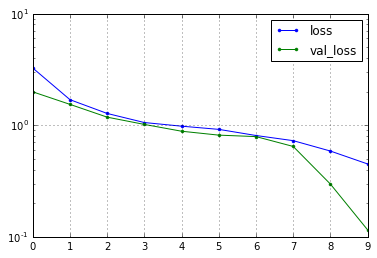

In [20]:
%matplotlib inline
h = pandas.DataFrame(out.history)
h[['loss', 'val_loss']].plot(logy=True, style='.-')
grid()

In [21]:
p = model_gmm.predict(X_train)

In [22]:
p.shape

(135, 12)

In [81]:
def get_params(params, M, D):
    mu = params[:M * D]
    sigma = params[M * D:(M * D + M)]
    alpha = params[M * D + M:]
    return mu, sigma, alpha
    
def gmm_pdf(y, params, M, D):
    mu = params[:M * D]
    sigma = params[M * D:(M * D + M)]
    alpha = params[M * D + M:]
    p = 0
    for i in range(M):
        p += alpha[i] * exp(- (y - mu[D * i:D * (i + 1)].squeeze()) ** 2 / sigma[i] ** 2 / 2) / np.sqrt(2 * np.pi) / sigma[i]
    return p

mu, sigma, alpha = get_params(p[0,:], M, D)

gmm_pdf(y_train[0], p[0,:], M, D)

array([ 0.0811942])

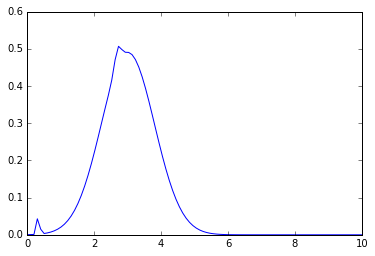

In [88]:
yl = linspace(0, 10, 100)
i = 0
plot(yl, gmm_pdf(yl, p[i,:], M, D))

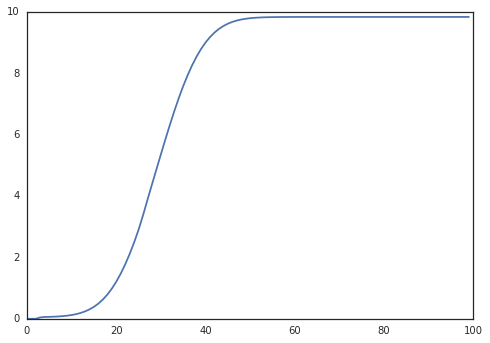

In [96]:
out = gmm_pdf(yl, p[i,:], M, D)
plot(out.cumsum())